In [1]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from keras import backend
from keras.applications import imagenet_utils
from keras.engine import training
from keras.layers import VersionAwareLayers
from keras.utils import data_utils
from keras.utils import layer_utils

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dir_ = Path('/content/drive/MyDrive/Colab Notebooks/Data/Dog_breeds_Dataset')
filepaths = list(dir_.glob(r'**/*.jpg'))
def proc_img(filepath):
    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepath, labels], axis=1)
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)

print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 3240

Number of different labels: 25

Labels: ['clumber' 'keeshond' 'black-and-tan_coonhound' 'komondor'
 'Blenheim_spaniel' 'Siberian_husky' 'Japanese_spaniel' 'otterhound'
 'Pomeranian' 'Welsh_springer_spaniel' 'Norwegian_elkhound' 'EntleBucher'
 'African_hunting_dog' 'basenji' 'Boston_bull' 'Yorkshire_terrier'
 'Shih-Tzu' 'silky_terrier' 'pug' 'standard_schnauzer' 'dingo' 'Leonberg'
 'Maltese_dog' 'beagle' 'Chihuahua']


In [62]:
def create_gen():
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(150, 150),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(150, 150),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(150, 150),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    return train_generator,test_generator,train_images,val_images,test_images

In [5]:
from tensorflow.python.util.tf_export import keras_export

BASE_WEIGHTS_PATH = (
    "https://storage.googleapis.com/tensorflow/keras-applications/densenet/"
)
DENSENET121_WEIGHT_PATH_NO_TOP = (
    BASE_WEIGHTS_PATH
    + "densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5"
)


In [7]:
layers = VersionAwareLayers()

def dense_block(x, blocks):
    for i in range(blocks):
        x = conv_block(x, 32)
    return x

In [8]:
def transition_block(x, reduction):
    bn_axis = 3
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5)(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(int(backend.int_shape(x)[bn_axis] * reduction), 1, use_bias=False)(x)
    x = layers.AveragePooling2D(2, strides=2)(x)
    return x

In [9]:
def conv_block(x, growth_rate):
    bn_axis = 3
    x1 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5)(x)
    x1 = layers.Activation("relu")(x1)
    x1 = layers.Conv2D(4 * growth_rate, 1, use_bias=False)(x1)
    x1 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5)(x1)
    x1 = layers.Activation("relu")(x1)
    x1 = layers.Conv2D(growth_rate, 3, padding="same", use_bias=False)(x1)
    x = layers.Concatenate(axis=bn_axis)([x, x1])
    return x

In [67]:
def model(): 

  blocks = [6, 12, 24, 16]
  weights = "imagenet"
  img_input = layers.Input(shape=(150,150,3))

  bn_axis = 3
  
  x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)))(img_input)
  x = layers.Conv2D(64, 7, strides=2, use_bias=False)(x)
  x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5)(x)
  x = layers.Activation("relu")(x)
  x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)))(x)
  x = layers.MaxPooling2D(3, strides=2)(x)

  x = dense_block(x, blocks[0])
  x = transition_block(x, 0.5)
  x = dense_block(x, blocks[1])
  x = transition_block(x, 0.5)
  x = dense_block(x, blocks[2])
  x = transition_block(x, 0.5)
  x = dense_block(x, blocks[3])

  x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5)(x)
  x = layers.Activation("relu")(x)

  x = layers.GlobalAveragePooling2D()(x)
  inputs = img_input

  model = training.Model(inputs, x)
  
  weights_path = data_utils.get_file(
                    "densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5",
                    DENSENET121_WEIGHT_PATH_NO_TOP,
                    cache_subdir="models",
                    file_hash="30ee3e1110167f948a6b9946edeeb738",
                )
  
  model.load_weights(weights_path)

  return model



pretrained_model = model()
pretrained_model.trainable = False
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(25, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

In [68]:
train_df,test_df = train_test_split(df, test_size=0.3, shuffle = True, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

history = model.fit(x = train_images, validation_data = val_images, epochs = 10)

Found 2042 validated image filenames belonging to 25 classes.
Found 226 validated image filenames belonging to 25 classes.
Found 972 validated image filenames belonging to 25 classes.
Epoch 1/10
64/64 [==============================] - 32s 218ms/step - loss: 1.0354 - accuracy: 0.7130 - val_loss: 0.4746 - val_accuracy: 0.8319
Epoch 2/10
64/64 [==============================] - 12s 180ms/step - loss: 0.2908 - accuracy: 0.9040 - val_loss: 0.4567 - val_accuracy: 0.8540
Epoch 3/10
64/64 [==============================] - 12s 184ms/step - loss: 0.1698 - accuracy: 0.9407 - val_loss: 0.4976 - val_accuracy: 0.8584
Epoch 4/10
64/64 [==============================] - 12s 181ms/step - loss: 0.1021 - accuracy: 0.9687 - val_loss: 0.3572 - val_accuracy: 0.8850
Epoch 5/10
64/64 [==============================] - 12s 186ms/step - loss: 0.0557 - accuracy: 0.9858 - val_loss: 0.3387 - val_accuracy: 0.9115
Epoch 6/10
64/64 [==============================] - 12s 187ms/step - loss: 0.0393 - accuracy: 0.9892 

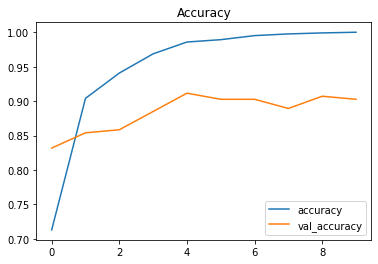

In [69]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

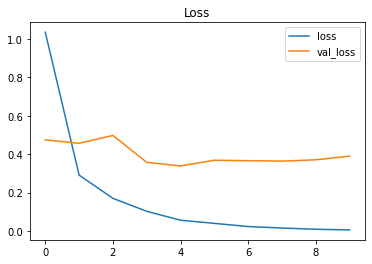

In [70]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [71]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

31/31 [==============================] - 7s 170ms/step
Accuracy on the test set: 90.53%
